In [1]:
# !. ../../pytorch-pose/venv/bin/activate
# !pip install progress

In [2]:
from __future__ import print_function, absolute_import
import os
import argparse
import time
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torchvision.datasets as datasets
import numpy as np
import _init_paths
from progress.bar import Bar
import pickle
from pose_code.hourglass import hg
from pose_code.atthourglass import atthg
from pose_code import JointsMSELoss
from pose_code.utils import *
from train_utils import *
from torch.utils.data import DataLoader 
import copy
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
## Load the prepared dataset
with open('../prepared_data/prepared_trainset_t1', 'rb') as file_pi:
     full = pickle.load(file_pi)
full[0] = full[0][:, :, :, :, 0]    

## Create a dataset loader
full_dataset_train = image_Dataset(image_paths=full[0], target_paths=full[1], use_flip = False)
MRI_train_loader = DataLoader(full_dataset_train, batch_size= 1, shuffle=False, num_workers=0)

In [5]:
All_skeletons = np.zeros((len(MRI_train_loader), 11, 2))
Joint_counter = np.zeros((11, 1))
for i, (input, target, vis) in enumerate(MRI_train_loader):
    #input  = input.numpy()
    #input = np.transpose(input, (0,2,3, 1))
    target = target.numpy()
    mask = np.zeros((target.shape[2], target.shape[3]))
    for idc in range(target.shape[1]):
        mask += target[0, idc]
    mask = np.uint8(np.where(mask>0, 1, 0))
    mask = np.rot90(mask)
    #cv2.imwrite('visualize/skeleton/1.png', mask*255)     
    #cv2.imwrite('visualize/skeleton/img.png', np.rot90(input[0]*255))
    num_labels, labels_im, states, centers = cv2.connectedComponentsWithStats(mask)
    centers = [t[::-1] for t in centers]
    skelet = np.zeros((11, 2))
    skelet[0:len(centers)-1] = centers[1:]
    Normjoint = np.linalg.norm(skelet[0]-skelet[4])
    #Normjoint = np.linalg.norm(skelet[0]-skelet[2])
#     print(skelet)
    for idx in range(1, len(centers)-1):
        skelet[idx] = (skelet[idx] - skelet[0]) / Normjoint

    skelet[0] *= 0
    
    All_skeletons[i] = skelet
    Joint_counter[0:len(centers)-1] += 1

13
14
14
13
14
14
13


In [6]:
Skelet = np.sum(All_skeletons, axis= 0)   
Skelet /= Joint_counter
    
# Skelet += 100

In [7]:
print(Skelet.shape)
print(All_skeletons.shape)
# plt.scatter(skelet[0])

(11, 2)
(212, 11, 2)


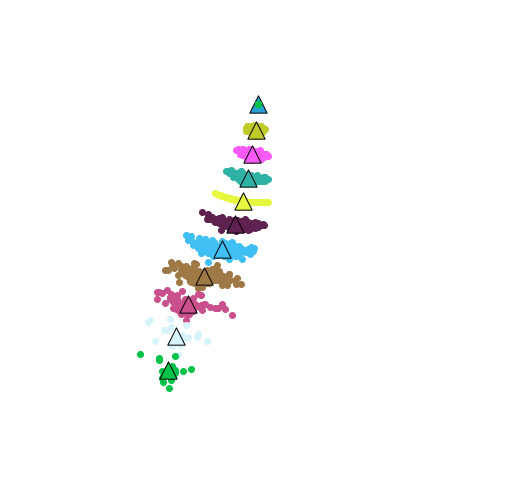

In [12]:
plt.figure(figsize=(9, 9))

colors = np.random.rand(11, 3)

for j in range(11):
    plt.scatter(All_skeletons[:, j, 1], -All_skeletons[:, j, 0], color=colors[j])
    plt.scatter([Skelet[j, 1]], [-Skelet[j, 0]], marker='^', color=colors[j], s=300, edgecolors='k')
# plt.scatter(Skelet[j, :], 'go')

# plt.axis('equal', 'box')
plt.axis('off')
plt.xlim(-2.5, 2.5)
plt.ylim(-4, 1)
plt.show()

In [ ]:
np.save('../prepared_dataset/T1_Skelet.npy', Skelet)